<a href="https://colab.research.google.com/github/dakyommii/study/blob/main/dduck/koGpt2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KoGpt2-train

##라이브러리 설치

In [1]:
!pip install fastai==2.2.5

     |████████████████████████████████| 191 kB 5.3 MB/s 
     |████████████████████████████████| 12.8 MB 22.1 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is inc

In [2]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 30.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.3 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re


In [4]:
print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.7.1
4.19.2
2.2.5


##KoGpt2 model, tokenizer 다운로드

In [5]:
#download model and tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

In [6]:
#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))  #문장을 토크나이저로 나눈다

#test model ouput
text = """저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다. """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다. ᄒ
이런저렇게 다양한 분야의 전문가들과 함께 하는 것이 좋겠습니다.</d> 오늘은 제가 좋아하는 과자 맛집 중 하나인 '와인나라' 를 소개해드리려고 합니다.
저는 와인을 좋아해서 와인나라에 자주 들렀습니다.
그곳에서 직접 만든 수제맥주를 마셔보고 싶은 마음에 찾아갔는데요.
제가 선택한 곳은 바로 이 곳입니다.
바로 이곳, 일명 '오렌지


##dataset 불러오기

In [7]:
with open('/content/drive/MyDrive/datasets/interview.csv') as f:
    lines = f.read()
lines=" ".join(lines.split())

lines=re.sub('"', ' ', lines)
lines=re.sub("'", ' ', lines)

##data 추가 후 train

###train/test 데이터 분할

In [8]:
#model input output tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
dls.show_batch(max_n=2)

,text,text_
0,"1,질문,응답 2,고객을 직접 응대하는 아르바이트를 한 경험이 있나요? 어떤 어려움이 있었나요?,컨벤션 홀에서 하는 행사에서 유인물을 나눠주거나 관람하지 않는 사람에게 홍보하는 아르바이트를 한 경험이 있습니다. 당시 주 타겟층은 아이였고 아이의 관심을 끌면서 홍보를 하는 것이 힘들었습니다. 아이의 흥미를 끌기 위해 아이가 흥미 있을만한 디즈니 관련 제품을 시연하며 홍보를 했습니다. 3,고객을 직접 응대하며 니즈를 파악하는 업무와 백엔드에서 개발을 하는 업무 중에 무엇을 선호하나요?,저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다. 4,만약 본인이 원하는 개발을 맡지 못하고 다른 개발을 맡기면 어떻게 할 것인가요?,저는 원래 가상현실과 증강현실을 하고 싶었습니다. 하지만 그 곳에서 웹과 인프라를 맡게 되었고 거기서도 흥미를 느낄 수 있었기 때문에 현재는 이 일을 직무로 하고 싶어하고 있습니다. 이렇듯 다른 업무라도 그 곳에서 흥미를 느끼고 잘 할 수 있을 것이라 생각합니다. 5,자기소개서에 쓰여진 프로젝트에서 자신의 역할을 자세히 설명해 주세요, 교내 데이터","질문,응답 2,고객을 직접 응대하는 아르바이트를 한 경험이 있나요? 어떤 어려움이 있었나요?,컨벤션 홀에서 하는 행사에서 유인물을 나눠주거나 관람하지 않는 사람에게 홍보하는 아르바이트를 한 경험이 있습니다. 당시 주 타겟층은 아이였고 아이의 관심을 끌면서 홍보를 하는 것이 힘들었습니다. 아이의 흥미를 끌기 위해 아이가 흥미 있을만한 디즈니 관련 제품을 시연하며 홍보를 했습니다. 3,고객을 직접 응대하며 니즈를 파악하는 업무와 백엔드에서 개발을 하는 업무 중에 무엇을 선호하나요?,저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다. 4,만약 본인이 원하는 개발을 맡지 못하고 다른 개발을 맡기면 어떻게 할 것인가요?,저는 원래 가상현실과 증강현실을 하고 싶었습니다. 하지만 그 곳에서 웹과 인프라를 맡게 되었고 거기서도 흥미를 느낄 수 있었기 때문에 현재는 이 일을 직무로 하고 싶어하고 있습니다. 이렇듯 다른 업무라도 그 곳에서 흥미를 느끼고 잘 할 수 있을 것이라 생각합니다. 5,자기소개서에 쓰여진 프로젝트에서 자신의 역할을 자세히 설명해 주세요, 교내 데이터"
1,"일을 하고 싶습니다. 61,소프트웨어 코딩에서 volatile이란 무엇입니까?, 갑자기 기억이 나지 않아 제대로 답변하지 못했습니다. volatile이란 말 그대로 휘발성이 있는, 날라가는 성질이 있는 이라는 뜻입니다. 변수 선언 시 앞에 volatile을 붙이게 되면, 이 변수의 내용이 언제든지 변할 수 있기 때문에 최적화 하지 말라는 뜻입니다. 62,협업(팀워크)에 중요한 역량은?,협업하는데 있어서 책임감이 가장 중요하다고 생각합니다. 서로의 목적 수행에 있어서 책임감을 가지고 일을 해낸다면 최고의 성취감을 느낄 수 있고 모두의 시너지를 발휘하여 공동의 목표 달성에 성공할 수 있기 때문입니다. 63,휴학 기간에 무엇을 하였나, 아버지가 전기 설비 쪽 일을 하시는데, 약 반년 정도 아버지를 도와 일을 하면서 많은 것을 배웠다고 답변했습니다. 64,직무 관련 과목 중 학점이 낮은 것이 있는데 무슨 이유인가?,4-1 과목이어서 취업 준비 때문에 공부가 미흡했었다고 솔직히 말하고 방학 때 다시 부족한 부분을 보충했다고 답변했습니다. 어느 부분을 보충했는지 구체적으로 설명했습니다. 65,지원한 직무에서 이루고 싶은 목표,평소 생각해왔던 진심어린 목표가 있었기 때문에 그대로 답변했습니다. 억지로 지어내지 않고 평소에도 생각해왔기","하고 싶습니다. 61,소프트웨어 코딩에서 volatile이란 무엇입니까?, 갑자기 기억이 나지 않아 제대로 답변하지 못했습니다. volatile이란 말 그대로 휘발성이 있는, 날라가는 성질이 있는 이라는 뜻입니다. 변수 선언 시 앞에 volatile을 붙이게 되면, 이 변수의 내용이 언제든지 변할 수 있기 때문에 최적화 하지 말라는 뜻입니다. 62,협업(팀워크)에 중요한 역량은?,협업하는데 있어서 책임감이 가장 중요하다고 생각합니다. 서로의 목적 수행에 있어서 책임감을 가지고 일을 해낸다면 최고의 성취감을 느낄 수 있고 모두의 시너지를 발휘하여 공동의 목표 달성에 성공할 수 있기 때문입니다. 63,휴학 기간에 무엇을 하였나, 아버지가 전기 설비 쪽 일을 하시는데, 약 반년 정도 아버지를 도와 일을 하면서 많은 것을 배웠다고 답변했습니다. 64,직무 관련 과목 중 학점이 낮은 것이 있는데 무슨 이유인가?,4-1 과목이어서 취업 준비 때문에 공부가 미흡했었다고 솔직히 말하고 방학 때 다시 부족한 부분을 보충했다고 답변했습니다. 어느 부분을 보충했는지 구체적으로 설명했습니다. 65,지원한 직무에서 이루고 싶은 목표,평소 생각해왔던 진심어린 목표가 있었기 때문에 그대로 답변했습니다. 억지로 지어내지 않고 평소에도 생각해왔기 때문에"


###loss 감소 부분 찾기

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)


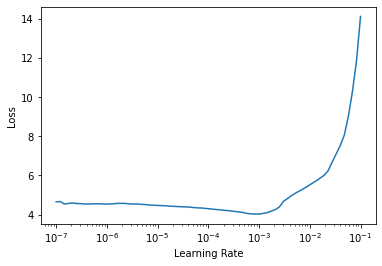

In [9]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)

####loss 감소 부분: 10^-7 ~ 10^-3

###기존 학습 모델에서 새로운 데이터 layer만 추가해서 학습

In [10]:
learn.fit_one_cycle(5,1e-4)  # 1e-4 는 10^-4

epoch,train_loss,valid_loss,perplexity,time
0,4.275125,3.702156,40.534615,00:29
1,3.745344,2.948642,19.080021,00:29
2,3.155298,2.397833,10.999313,00:29
3,2.647734,2.083642,8.033670,00:29
4,2.263861,2.011103,7.471551,00:29


###save model

In [11]:
learn.model.save_pretrained("/content/drive/MyDrive/result/KoGpt2")  #모델 저장

##test

In [13]:
prompt="저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다. "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=500,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
sentence = tokenizer.decode(preds[0].cpu().numpy())
print(sentence)

저는 성격상 낯을 가리는 경향이 있기 때문에 모르는 사람을 많이 만나서 응대하는 것 보다 백엔드 개발을 선호합니다. 또한 저는 백엔드 개발을 하고 싶어서 해당 직무에 지원한 만큼 백엔드 개발을 선호합니다.  499,본인이 가장 힘들었던 순간과 어떻게 극복했는지?, 제가 일탈했던 것은 부모님이 결별하신 것이 직접적인 계기가 되어 빚어진 것입니다. 그 충격으로 인해 혼자 할 수 있는 일이 많아져 혼자서 감당하기 힘든 상황에 놓였습니다. 그래서 아르바이트를 하면서도, 친구들과 놀기도 해서 하루하루가 힘겹기만 했었지 얼마나 많은 것을 배웠는지 모른다고 하셨고 그래도 극복할 자신이 있다고 말씀 드렸습니다. 451,가장 기억 남는 프로젝트는 무엇입니까. 라고 질문하셔서, 제 인생에서 제일 큰 영향을 준 프로젝트라고 답변했음 352,최근 이슈인 EUV(우직하다고 하는 Volatile) 관련해서 말함. 최근 유럽연합(Europe) 통계나 통계를 보면 ECB의 물가안정 목표치는 2%인데 실제로는 이보다 훨씬 높은 3%를 설정하고 있어 인플레이션이 우려된다고 함. 이를 달성하기 위해선 중앙은행들이 통화정책을 운용해야 한다고 생각한다고 대답함 343,마지막 한마디 하겠음,왜 유로존 국가 중 한국만 유독 그렇게 생각하는거죠?
그 이유는 바로 우리 경제가 더블딥(이중침체)에 빠질 가능성이 높다는 전망 때문입니다. 따라서 지금 이 위기를 기회로 삼아야하고, 더 나아가 새로운 성장동력을 창출할수 있도록 해야하고 그러기 위해서는 한국은행도 한은 같은 역할을 해내야만 한다는 생각이 들었기 때문이라고 설명하면서 추가적인 금리 인하를 단행하지 않는다면 금리를 인하해 경기를 부양시켜야한다는 생각을 갖게 됐다는 말을 하였음. 394,우리 경제에 대해 아는 게 있습니까 (실제로는 잘 모르겠지만 다른 나라보다 먼저 알고 있었음) 왜 이렇게 보는 거 같냐면,저는 항상 자신있게 말할 준비가 안되어있다. 하지만 가끔씩 외국인들에게 물어보는 질문을 받곤 한다. 그런 적이 한두번 정도 있다. 내가 만약 외국인